## Burgers equation
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

In [202]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, NN): 
        super(Net, self).__init__()

        self.input_layer = nn.Linear(2, NN)
        self.hidden_layer1 = nn.Linear(NN,int(NN/2)) 
        self.hidden_layer2 = nn.Linear(int(NN/2), int(NN/2))  
        self.output_layer = nn.Linear(int(NN/2), 1)
        

    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer1(out))
        out = torch.tanh(self.hidden_layer2(out))
        out_final = self.output_layer(out)
        return out_final


# Define the neural network architecture
#NN = nn.Sequential(nn.Linear(2, neurons), nn.Sigmoid(), nn.Linear(neurons, 1, bias=True))


In [203]:
pred = Net(100)
# Define the optimizer
adam = torch.optim.Adam(pred.parameters(), lr=0.001)
#mse = torch.nn.MSELoss(reduction='mean') 

# initialization
w = torch.tensor(50.0, requires_grad=True)
adam_optimizer = torch.optim.Adam([w], lr=0.001)

lbfgs_optimizer = torch.optim.LBFGS([w], max_iter=100, tolerance_grad=1.e-12, tolerance_change=1.e-12)

t_collocation = np.random.uniform(low=0.0, high=1.0, size=(200, 1))
x_collocation = np.random.uniform(low=-1.0, high=1.0, size=(200, 1))

t = torch.tensor(t_collocation, dtype=torch.float32, requires_grad=True)
x = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

spatial_coords = torch.cat([t, x], 1)


In [204]:
z_0 = torch.zeros_like(t)
z_1 = torch.ones_like(t)
z_2 = torch.full_like(t, -1)

bc_1 = torch.cat((z_0, x), dim=1)
bc_2 = torch.cat((t, z_1), dim=1)
bc_3 = torch.cat((t, z_2), dim=1)


def bc_function(t, x):
    # Define the bc function
    f = -torch.sin(np.pi * x)
    return f

# Define the boundary condition function (homogeneous Dirichlet boundary condition)
def boundary_condition(t, x):
    return torch.zeros_like(x)  # Zero value boundary condition

    
def loss_adam(optimizer, inputs, w):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    # pde_residual
    loss1 = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    loss2 = pred(bc_1) - bc_function(t, x) # boundary_residual_1
    loss3 = pred(bc_2) - boundary_condition(t, x) # boundary_residual_2
    loss4 = pred(bc_3) - boundary_condition(t, x) # boundary_residual_3

    for epoch in range(100):
        optimizer.zero_grad()  
        total_loss = w * torch.mean(loss1**2)+ (1/w) * (torch.mean(loss2**2)+torch.mean(loss3**2)+torch.mean(loss4**2))
        total_loss.backward(retain_graph=True)
        optimizer.step()

        # Print and/or log the optimized weights for monitoring
        # print(f"Epoch [{epoch+1}/{100}], Loss: {total_loss.item()}, Loss Weights: {w.item()}, {1/w.item()}")

    return torch.tensor(total_loss.item(), requires_grad=True)


def loss_lbfgs(optimizer, inputs, w):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    # pde_residual
    loss1 = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    loss2 = pred(bc_1) - bc_function(t, x) # boundary_residual_1
    loss3 = pred(bc_2) - boundary_condition(t, x) # boundary_residual_2
    loss4 = pred(bc_3) - boundary_condition(t, x) # boundary_residual_3
    

    def closure(optimizer):
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        total_loss = w * torch.mean(loss1**2) + (1/w) * (torch.mean(loss2**2) + torch.mean(loss3**2) + torch.mean(loss4**2))
        if total_loss.requires_grad:
                total_loss.backward(retain_graph=True)
        return total_loss

    for epoch in range(100): 
        optimizer.step(lambda: closure(optimizer))
        total_loss = closure(optimizer)
        #print(f"Epoch [{epoch+1}/{100}], Loss: {total_loss.item()}")

    return torch.tensor(total_loss.item(), requires_grad=True)

Epoch 1, Loss: 0.010526358149945736, Loss Weights: 55.123626708984375, 0.018141041504386612
Epoch 2, Loss: 0.010469535365700722, Loss Weights: 55.21466064453125, 0.01811113186836267
Epoch 3, Loss: 0.010419147089123726, Loss Weights: 55.3065185546875, 0.018081051314253173
Epoch 4, Loss: 0.010373268276453018, Loss Weights: 55.399131774902344, 0.018050824407559278
Epoch 5, Loss: 0.010330300778150558, Loss Weights: 55.49238586425781, 0.01802049027854273
Epoch 6, Loss: 0.010289055295288563, Loss Weights: 55.586181640625, 0.017990082615589355
Epoch 7, Loss: 0.010248788632452488, Loss Weights: 55.68039321899414, 0.017959643281737315
Epoch 8, Loss: 0.010209126397967339, Loss Weights: 55.775089263916016, 0.017929151045697297
Epoch 9, Loss: 0.01017005555331707, Loss Weights: 55.87017822265625, 0.017898636299579298
Epoch 10, Loss: 0.010131805203855038, Loss Weights: 55.965545654296875, 0.017868136338329847
Epoch 11, Loss: 0.010094691067934036, Loss Weights: 56.06129455566406, 0.017837618769346926

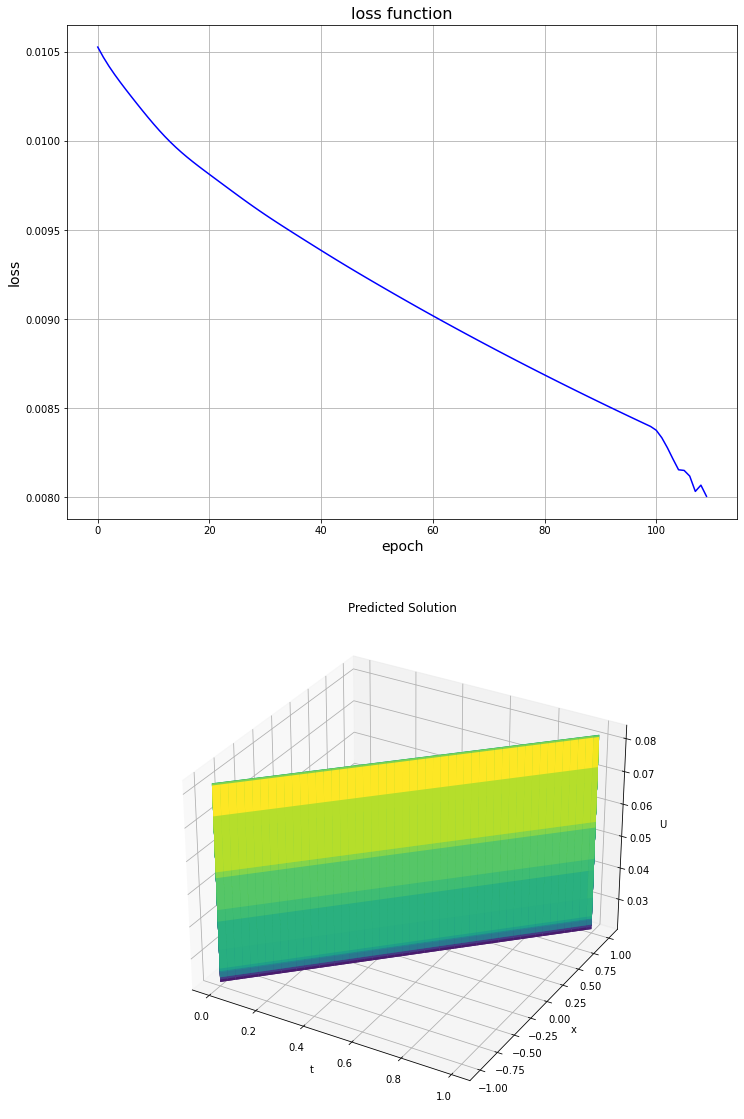

In [207]:
#torch.autograd.set_detect_anomaly(True)
def train(optimizer, epochs):
    lossList = []
    epochList = []

    for epoch in range(epochs):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_adam(adam_optimizer, spatial_coords, w)  # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step() 
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}, Loss Weights: {w.item()}, {1/w.item()}") 
        lossList.append(loss_val.item())
        epochList.append(epoch)

    for epoch in range(epochs, epochs+10):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_lbfgs(lbfgs_optimizer, spatial_coords, w) # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}") 
        #total_loss += loss_val.item()
        lossList.append(loss_val.item())
        epochList.append(epoch)    

    
    uNN = pred(spatial_coords).detach().numpy()
    #pred_grid = uNN.view(100, 100).numpy()

    fig = plt.figure(figsize=(12, 20))

    
    ax_t = np.linspace(0, 1, 200)
    ax_x = np.linspace(-1, 1, 200)
    

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(epochList, lossList, linestyle='-', color='blue')
    ax1.set_title('loss function', fontsize=16)
    ax1.set_xlabel('epoch', fontsize=14)
    ax1.set_ylabel('loss', fontsize=14)
    ax1.grid(True)

    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    ax2.plot_surface(ax_t, ax_x, uNN, cmap='viridis')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('U')
    ax2.set_title('Predicted Solution')

    
    plt.savefig('loss.png')
    #plt.tight_layout()
    plt.show()
    

# Train the neural network
train(adam, 100)